In [69]:
import numpy as np
import glob
import os

def load_suite2p_file(file_path):
    """Load suite2p files with special handling for ops.npy"""
    var_name = os.path.basename(file_path).replace('.npy', '')
    
    if var_name == 'ops':
        data = np.load(file_path, allow_pickle=True).item()
        print(f"Loaded: {var_name} (dictionary)")
    else:
        data = np.load(file_path, allow_pickle=True)
        print(f"Loaded: {var_name} with shape {data.shape}")
    
    return var_name, data

folder_path = 'X:\\Boaz_CA\\suite2p-20251014T174430Z-1-001\\suite2p\\plane0'  # Adjust to your folder path <<<<<
output_dir = 'X:\\Boaz_CA\\analysis'  # Adjust to your desired output directory <<<<
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

npy_files = glob.glob(os.path.join(folder_path, '*.npy'))

# Use the function in your loop
for file_path in npy_files:
    var_name, data = load_suite2p_file(file_path)
    globals()[var_name] = data
    
print(f"Shape: {spks.shape}")
# Now you can directly use the variables
# print(train_data)  # if you had train_data.npy
# print(test_labels) # if you had test_labels.npy

# keep only putative cells (Neurons)
is_cell_mask = iscell[:, 0].astype(bool) # Gets the first column as boolean

F_cells = F[is_cell_mask, :]
Fneu_cells = Fneu[is_cell_mask, :]
spks_cells = spks[is_cell_mask, :]
stat_cells = stat[is_cell_mask] # Note: 'stat' is a list, not an array

neuropil_coeff = ops['neucoeff'] # This is the coefficient used
fs = ops['fs'] # Sampling rate (Hz)
F_corrected_cells = F_cells - neuropil_coeff * Fneu_cells

Loaded: F with shape (34, 4215)
Loaded: Fneu with shape (34, 4215)
Loaded: iscell with shape (34, 2)
Loaded: ops (dictionary)
Loaded: spks with shape (34, 4215)
Loaded: stat with shape (34,)
Shape: (34, 4215)


In [ ]:
### check data
import plotly.graph_objects as go
import numpy as np

# Assuming spks is a 2D NumPy array: shape (n_signals, n_timepoints)
# data = Fneu
# data = spks
data = F_corrected_cells

# Get number of signals
n_signals = data.shape[0]
timevec = np.arange(data.shape[1]) / fs  # Time vector in seconds

# Normalize each signal between 0 and 1
data_normalized = np.zeros_like(data, dtype=float)
for i in range(n_signals):
    min_val = np.min(data[i])
    max_val = np.max(data[i])
    data_normalized[i] = (data[i] - min_val) / (max_val - min_val) if max_val != min_val else 0

# Vertical offset between signals
offset = 1.5
y_positions = np.arange(n_signals) * offset

# Create figure
fig = go.Figure()

# Add each signal as a line trace
for i in range(n_signals):
    fig.add_trace(go.Scatter(
        y=data_normalized[i] + y_positions[i],
        x=timevec,
        mode='lines',
        line=dict(width=1),
        name=f'Signal {i+1}',
        hovertemplate=f'Time: %{{x}}<br>Amplitude: %{{y:.3f}}<br>Signal: {i+1}<extra></extra>'
    ))

# Update layout with black background
fig.update_layout(
    title='Ca2+ signals',
    xaxis_title='Time (s)',
    yaxis_title='Signal Index',
    yaxis=dict(
        tickvals=y_positions,
        ticktext=[f'cell {i+1}' for i in range(n_signals)]
    ),
    height=800,
    showlegend=False,
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
)

fig.show()


In [26]:
print(np.max(timevec))

602.0


In [70]:
# filter data 
from scipy.signal import butter, filtfilt

def butter_filter(signal, lowcut=None, highcut=None, fs=30, order=3):
    """
    Bandpass or lowpass filter using a Butterworth filter.
    - signal: 1D array
    - lowcut: lower cutoff frequency (Hz), optional
    - highcut: upper cutoff frequency (Hz), optional
    - fs: sampling rate (Hz)
    - order: filter order
    """
    nyq = 0.5 * fs  # Nyquist frequency
    
    if lowcut and highcut:
        btype = 'band'
        Wn = [lowcut / nyq, highcut / nyq]
    elif highcut:
        btype = 'low'
        Wn = highcut / nyq
    elif lowcut:
        btype = 'high'
        Wn = lowcut / nyq
    else:
        return signal  # no filtering
    
    b, a = butter(order, Wn, btype=btype)
    filtered = filtfilt(b, a, signal)
    return filtered

# apply filter to each signal
offset = .5
# Filter parameters
cutoff0 = 0.01  # Hz, typically good for calcium (slow) dynamics
cutoff1 = 1  # Hz, typically good for calcium (slow) dynamics

data_filt = np.zeros_like(data_normalized)
for i in range(data_filt.shape[0]):
    trace = data_normalized[i]
    trace_filt = butter_filter(trace, lowcut=cutoff0, highcut=cutoff1, fs=fs, order=2)
    data_filt[i] = trace_filt

data = data_filt # grab filtered data
n_signals = data.shape[0]
y_positions = np.arange(n_signals) * offset

# Create figure
fig = go.Figure()

# Add each signal as a line trace
for i in range(n_signals):
    fig.add_trace(go.Scatter(
        y=data[i] + y_positions[i],
        x=timevec,
        mode='lines',
        line=dict(width=1),
        name=f'Signal {i+1}',
        hovertemplate=f'Time: %{{x}}<br>Amplitude: %{{y:.3f}}<br>Signal: {i+1}<extra></extra>'
    ))

# Update layout with black background
fig.update_layout(
    title='Ca2+ signals',
    xaxis_title='Time (s)',
    yaxis_title='Signal Index',
    yaxis=dict(
        tickvals=y_positions,
        ticktext=[f'cell {i+1}' for i in range(n_signals)]
    ),
    height=800,
    showlegend=False,
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
)

fig.show()
    

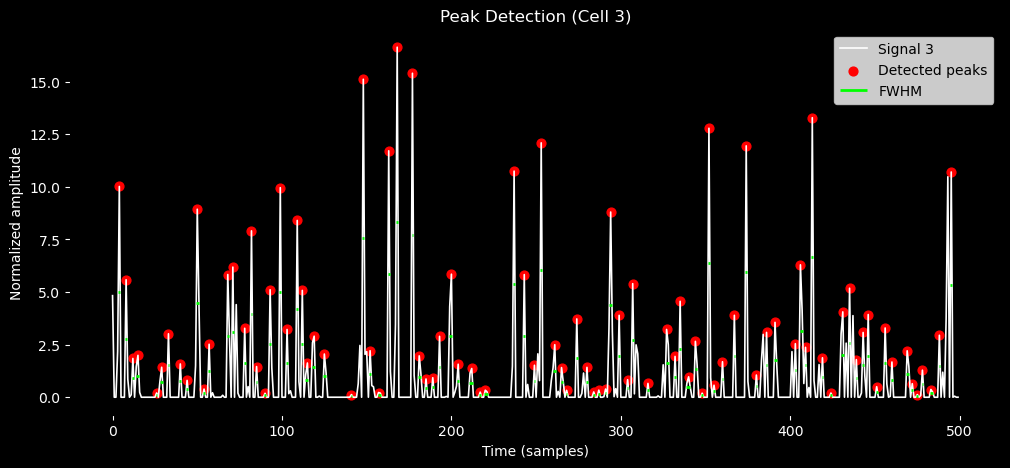

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths

# Choose which channel to inspect
ch = 4  # change to another index to test others
trace = data[ch]

# Try some starting parameters — adjust these
height_thr = 0.05
prom_thr = 0.01
min_dist = fs // 2  # Minimum distance between peaks in samples

# Detect peaks
peaks, properties = find_peaks(trace, height=height_thr, prominence=prom_thr, distance=min_dist)

# Compute widths (FWHM)
widths, width_heights, left_ips, right_ips = peak_widths(trace, peaks, rel_height=0.5)

# Plot the trace and detected peaks
plt.figure(figsize=(12,5))
plt.plot(trace, color='white', lw=1.2, label=f'Signal {ch+1}')
plt.scatter(peaks, trace[peaks], color='red', s=40, label='Detected peaks')
plt.hlines(width_heights, left_ips, right_ips, color='lime', lw=2, label='FWHM')

plt.title(f'Peak Detection (Cell {ch+1})', color='white')
plt.xlabel('Time (samples)', color='white')
plt.ylabel('Normalized amplitude', color='white')
plt.legend()

# Black background?
plt.gca().set_facecolor('black')
plt.gcf().patch.set_facecolor('black')
plt.tick_params(colors='white')
plt.show()


In [73]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, peak_widths

data = data_filt  # Use the filtered data from previous step
n_channels = data.shape[0]
dt = 1 / fs

results = []

for ch in range(n_channels):
    trace = data[ch]

    # Detect peaks using the same parameters as before
    peaks, properties = find_peaks(trace, height=height_thr, prominence=prom_thr, distance=min_dist)

    # Compute FWHM
    widths, width_heights, left_ips, right_ips = peak_widths(trace, peaks, rel_height=0.5)
    fwhm_time = widths * dt  # Convert to seconds

    # Store results
    for i, peak in enumerate(peaks):
        results.append({
            'Cell': ch + 1,
            'PeakIndex': peak,
            'PeakHeight': properties['peak_heights'][i],
            'FWHM_samples': widths[i],
            'FWHM_time': fwhm_time[i]
        })

# Convert to DataFrame for easy inspection
df_peaks = pd.DataFrame(results)
print(df_peaks.head())
# save to CSV
df_peaks.to_csv(os.path.join(output_dir, 'detected_peaks.csv'), index=False)

   Cell  PeakIndex  PeakHeight  FWHM_samples  FWHM_time
0     1       3328    0.065849      7.479959   1.068566
1     1       3339    0.072459    140.955651  20.136522
2     1       3383    0.067889     35.869218   5.124174
3     1       3543    0.061782     23.786692   3.398099
4     1       3650    0.197320     26.893013   3.841859


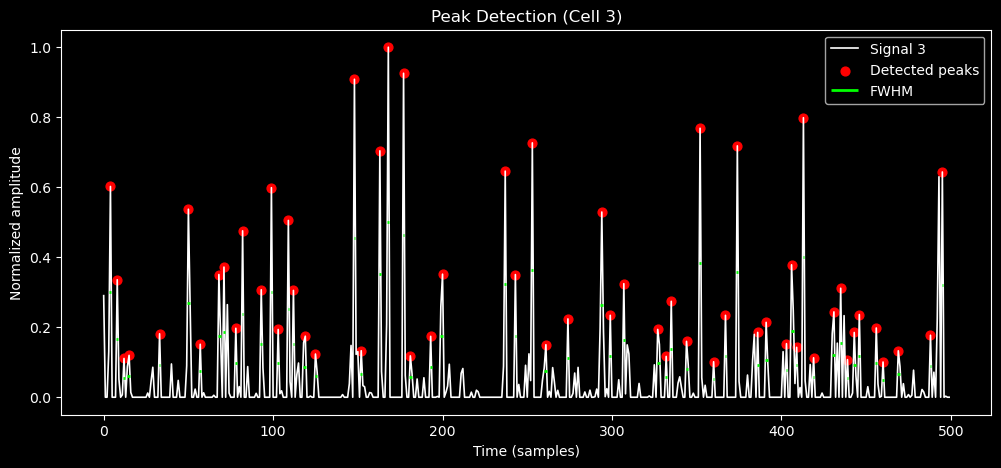

   Cell  PeakIndex  PeakTime  PeakHeight
0     1          4  0.571429    0.174381
1     1         12  1.714286    0.162470
2     1         27  3.857143    0.161424
3     1         31  4.428571    0.200527
4     1         55  7.857143    0.109146


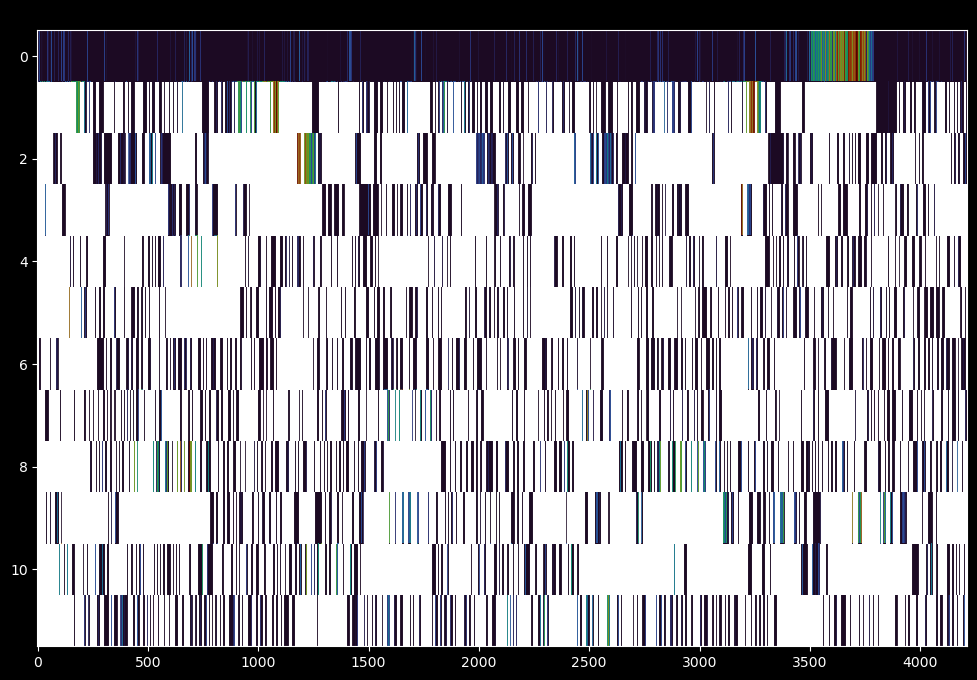

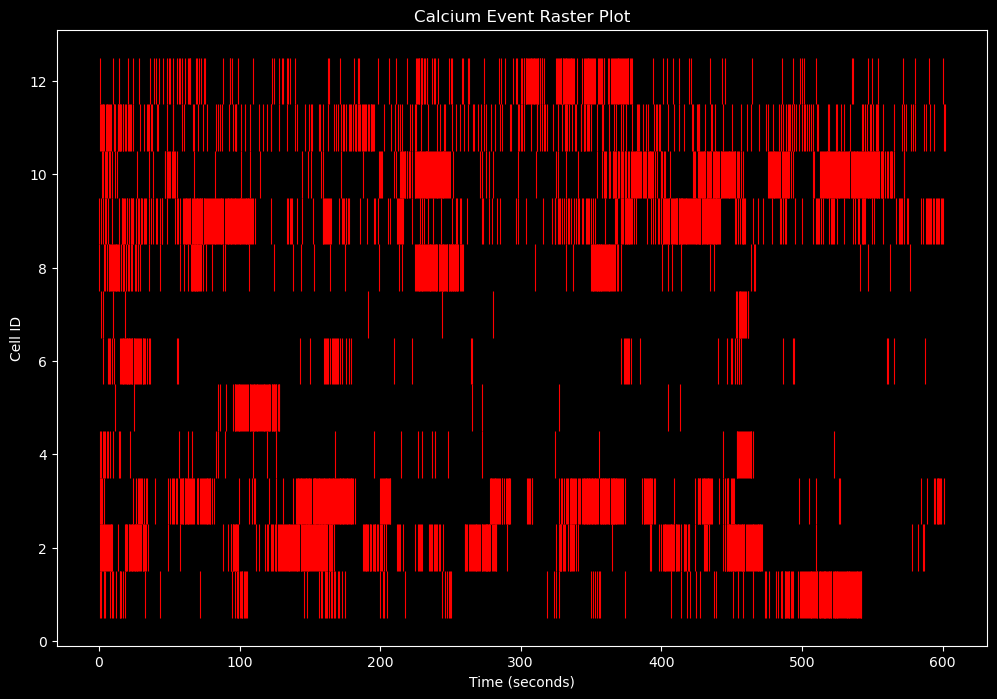

In [ ]:
# detect peaks in spks_cells and plot a raster plot
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths

# Choose which channel to inspect
ch = 2  # change to another index to test others
# get 500 random samples from the signal
rng = np.random.default_rng(42)
sample_indices = rng.choice(spks_cells.shape[1], size=500, replace=False)
trace = spks_cells[ch, sample_indices]
norm_trace = (trace - np.min(trace)) / (np.max(trace) - np.min(trace))

# Try some starting parameters — adjust these
height_thr = 0.1
prom_thr = 0.01
min_dist = fs // 2  # Minimum distance between peaks in samples

# Detect peaks
peaks, properties = find_peaks(norm_trace, height=height_thr, prominence=prom_thr, distance=min_dist)

# Compute widths (FWHM)
widths, width_heights, left_ips, right_ips = peak_widths(norm_trace, peaks, rel_height=0.5)

# Plot the norm_trace and detected peaks
plt.figure(figsize=(12,5))
plt.plot(norm_trace, color='white', lw=1.2, label=f'Signal {ch+1}')
plt.scatter(peaks, norm_trace[peaks], color='red', s=40, label='Detected peaks')
plt.hlines(width_heights, left_ips, right_ips, color='lime', lw=2, label='FWHM')

plt.title(f'Peak Detection (Cell {ch+1})', color='white')
plt.xlabel('Time (samples)', color='white')
plt.ylabel('Normalized amplitude', color='white')
plt.legend()

# Black background?
plt.gca().set_facecolor('black')
plt.gcf().patch.set_facecolor('black')
plt.tick_params(colors='white')
plt.show()

# plot raster of all cells
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
for i in range(spks_cells.shape[0]):
    spike_times = np.where(spks_cells[i] > 0)[0]
    plt.vlines(spike_times, i + 0.5, i + 1.5, color='white')

norm_spks = np.zeros_like(spks_cells, dtype=float)
for i in range(spks_cells.shape[0]):
    min_val = np.min(spks_cells[i])
    max_val = np.max(spks_cells[i])
    norm_spks[i] = (spks_cells[i] - min_val) / (max_val - min_val) if max_val != min_val else 0

#check
plt.imshow(norm_spks, aspect='auto', cmap='turbo', interpolation='nearest', alpha=0.6)
plt.title('Spks_norm', color='black')

data = norm_spks  # Use the filtered data from previous step
n_channels = data.shape[0]
dt = 1 / fs

resultsSpks = []

for ch in range(n_channels):
    trace = data[ch]

    # Detect peaks using the same parameters as before
    peaks, properties = find_peaks(trace, height=height_thr, prominence=prom_thr, distance=min_dist)
    # convert peak indices to time
    peak_times = peaks * dt
    # Store results
    for i, peak in enumerate(peaks):
        resultsSpks.append({
            'Cell': ch + 1,
            'PeakIndex': peak,
            'PeakTime': peak_times[i],
            'PeakHeight': properties['peak_heights'][i],
        })

# Convert to DataFrame for easy inspection
df_peaks_Spks = pd.DataFrame(resultsSpks)
print(df_peaks_Spks.head())
# save to CSV
df_peaks_Spks.to_csv(os.path.join(output_dir, 'detected_peaks_spks.csv'), index=False)
    

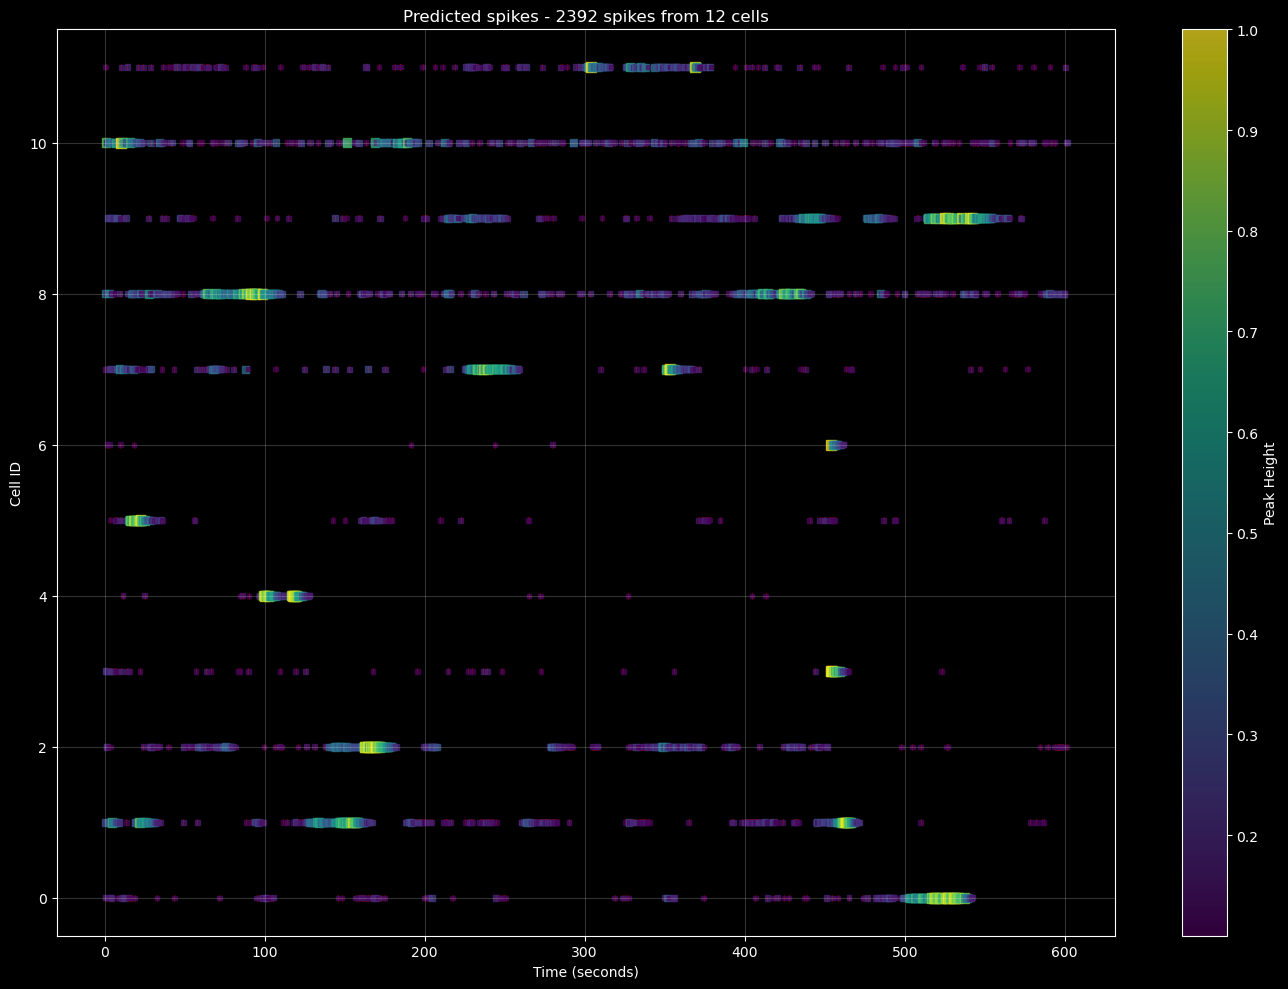

In [97]:
plt.figure(figsize=(14, 10))

# Method 1: Simple scatter
cell_ids = []
spike_times_list = []
peak_heights = []

for i in range(spks_cells.shape[0]):
    cell_data = df_peaks_Spks[df_peaks_Spks['Cell'] == i + 1]
    spike_times = cell_data['PeakTime'].values
    heights = cell_data['PeakHeight'].values
    
    cell_ids.extend([i] * len(spike_times))
    spike_times_list.extend(spike_times)
    peak_heights.extend(heights)

# Convert to numpy arrays for easier manipulation
cell_ids = np.array(cell_ids)
spike_times_list = np.array(spike_times_list)
peak_heights = np.array(peak_heights)

# Option A: Uniform markers
plt.scatter(spike_times_list, cell_ids, color='red', s=20, alpha=0.7, marker='|', linewidth=1)

# Option B: Size proportional to peak height (if you want to show amplitude)
if len(peak_heights) > 0:
    # Normalize sizes for better visualization
    sizes = 10 + 40 * (peak_heights - peak_heights.min()) / (peak_heights.max() - peak_heights.min())
    plt.scatter(spike_times_list, cell_ids, c=peak_heights, s=sizes, alpha=0.7, 
                cmap='viridis', marker='s')  # square markers
    plt.colorbar(label='Peak Height')

plt.xlabel('Time (seconds)')
plt.ylabel('Cell ID')
plt.title(f'Predicted spikes - {len(spike_times_list)} spikes from {spks_cells.shape[0]} cells')
plt.grid(True, alpha=0.2)
plt.ylim(-0.5, spks_cells.shape[0] - 0.5)
plt.tight_layout()
plt.show()